In [1]:
import numpy as np  # this module handles arrays, but here we need it for its NaN value
import pandas as pd # this module contains a lot of tools for handling tabular data
from matplotlib import pyplot as plt
from salishsea_tools import evaltools as et
import datetime as dt
import os
import gsw
import pickle
import netCDF4 as nc
import cmocean
from scipy import stats as spst
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [2]:
# Parameters
modSourceDir = "/results2/SalishSea/nowcast-green.201905/"
modver = "201905"
Chl_N = 1.8
start_date = dt.datetime(2015,1,1)
end_date = dt.datetime(2018,12,31)
clusterD='/data/tjarniko/MEOPAR/analysis_tereza/notebooks/CLUSTER_PAPER/CLEAN/KEY_PAPERFIGURES/pkls/'
cxf='Xcoords_for571_stations.pkl'
cyf='Ycoords_for571_stations.pkl'
cfile={2015:'BIO_clno_5_2015_reass.pkl',
       2016:'BIO_clno_5_2016_reass.pkl'} # only 2015 and 2016 overlap with hplc

In [3]:
def logt(x):
    return np.log10(x+.001)

## First, assign each row of HPLC data frame a cluster ID

In [4]:
cx=pickle.load(open(clusterD+cxf, 'rb'))
cy=pickle.load(open(clusterD+cyf, 'rb'))

In [5]:
cf=dict()
for iyear in cfile.keys():
    cf[iyear]=pickle.load(open(clusterD+cfile[iyear],'rb'))

In [6]:
cx[:5],cy[:5]

(array([12, 12, 12, 12, 12]), array([382, 392, 402, 412, 422]))

In [7]:
# 7-16=>12; 17-26=>22, etc
def round2(num):
    return int(np.trunc((num+2)/10)*10+2)

In [8]:
datestr='_'+start_date.strftime('%Y%m%d')+'_'+end_date.strftime('%Y%m%d')
data=pickle.load(open( 'matched_'+modver+datestr+'.pkl', 'rb' ) )

data['other']=0.0
for el in ('Cryptophytes', 'Cyanobacteria', 'Dictyochophytes', 'Dinoflagellates',
    'Haptophytes', 'Prasinophytes', 'Raphidophytes'):
    data['other']=data['other']+data[el]
    
def yd(idt):
    if type(idt)==dt.datetime:
        yd=(idt-dt.datetime(idt.year-1,12,31)).days
    else: # assume array or pandas
        yd=[(ii-dt.datetime(ii.year-1,12,31)).days for ii in idt]
    return yd

data['yd']=yd(data['dtUTC'])
data['Year']=[ii.year for ii in data['dtUTC']]

data['mod_diatoms_chl']=Chl_N*data['mod_diatoms']
data['mod_flagellates_chl']=Chl_N*data['mod_flagellates']
data['mod_ciliates_chl']=Chl_N*data['mod_ciliates']
data['mod_TChl']=data['mod_diatoms_chl']+data['mod_flagellates_chl']+data['mod_ciliates_chl']
data['CCPH']=data['Cyanobacteria']+data['Cryptophytes']+data['Prasinophytes']+data['Haptophytes']
data['DD']=data['Diatoms-1']+data['Diatoms-2']
data2=data.loc[(data.Year<2017)&(data.i>7)]
data=data2.copy(deep=True).reset_index()

In [9]:
data['Cluster']=np.zeros(len(data))

In [10]:
for ir, row in data.iterrows():
    ii=(cx==round2(row['i']))&(cy==round2(row['j']))
    if sum(ii)==1:
        cluster=cf[row['Year']][ii]
        data.at[ir,'Cluster']=int(cluster)

In [11]:
np.sum(data['Cluster']==0),len(data)

(62, 2238)

### map HPLC data by cluster; 0 was not close to a cluster point

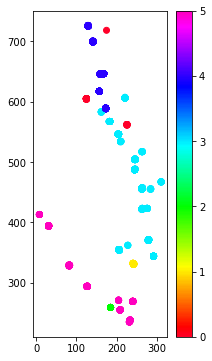

In [12]:
fig,ax=plt.subplots(1,1,figsize=(3,6))
m=ax.scatter(data['i'],data['j'],c=data['Cluster'],cmap='gist_rainbow')
fig.colorbar(m)

In [13]:
print('number of data points in each cluster:')
data.loc[:,['Cluster','index']].groupby('Cluster').count()

number of data points in each cluster:


,index
Cluster,
0.0,62
1.0,102
2.0,32
3.0,1096
4.0,441
5.0,505


### plot Diatoms versus HPLC Diatoms 1 and 2 and flagellates versus HPLC CCPH=cyano+crypto+prasino+hapto for each cluster

Text(0.5, 1.0, 'Model vs. HPLC')

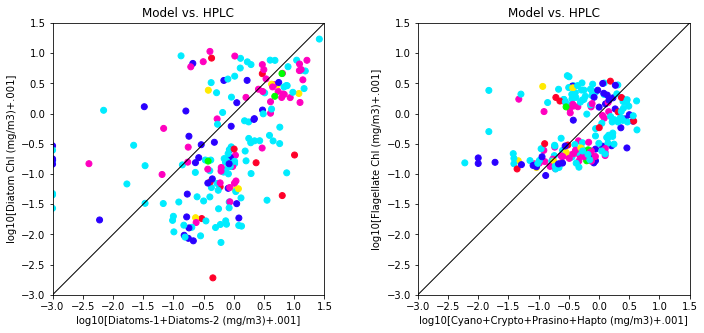

In [14]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
m=ax[0].scatter(logt(data['DD']),logt(data['mod_diatoms_chl']),c=data['Cluster'],cmap='gist_rainbow')
ax[0].set_aspect(1)
ax[0].set_xlim(-3,1.5)
ax[0].set_ylim(-3,1.5)
ax[0].plot((-3,1.5),(-3,1.5),'k-',lw=1)
ax[0].set_xlabel('log10[Diatoms-1+Diatoms-2 (mg/m3)+.001]')
ax[0].set_ylabel('log10[Diatom Chl (mg/m3)+.001]')
ax[0].set_title('Model vs. HPLC')
ax[1].scatter(logt(data['CCPH']),logt(data['mod_flagellates_chl']),c=data['Cluster'],cmap='gist_rainbow')
ax[1].set_aspect(1)
ax[1].set_xlim(-3,1.5)
ax[1].set_ylim(-3,1.5)
ax[1].plot((-3,1.5),(-3,1.5),'k-',lw=1)
ax[1].set_xlabel('log10[Cyano+Crypto+Prasino+Hapto (mg/m3)+.001]')
ax[1].set_ylabel('log10[Flagellate Chl (mg/m3)+.001]')
ax[1].set_title('Model vs. HPLC')
#fig.colorbar(m)

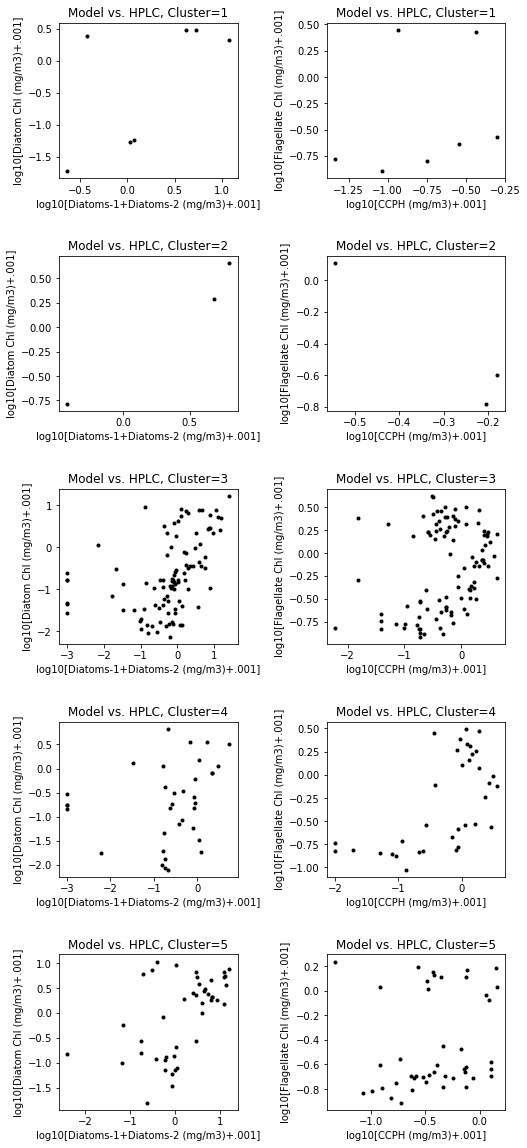

In [15]:
fig,ax=plt.subplots(5,2,figsize=(8,20))
fig.subplots_adjust(hspace=.5,wspace=.5)
for el in range(1,6):
    idata=data.loc[data.Cluster==el]
    ax[el-1,0].plot(logt(idata['DD']),logt(idata['mod_diatoms_chl']),'k.')
    ax[el-1,0].set_xlabel('log10[Diatoms-1+Diatoms-2 (mg/m3)+.001]')
    ax[el-1,0].set_ylabel('log10[Diatom Chl (mg/m3)+.001]')
    ax[el-1,0].set_title('Model vs. HPLC, Cluster='+str(el))
    
    ax[el-1,1].plot(logt(idata['CCPH']),logt(idata['mod_flagellates_chl']),'k.')
    ax[el-1,1].set_xlabel('log10[CCPH (mg/m3)+.001]')
    ax[el-1,1].set_ylabel('log10[Flagellate Chl (mg/m3)+.001]')
    ax[el-1,1].set_title('Model vs. HPLC, Cluster='+str(el))

### as chl fraction

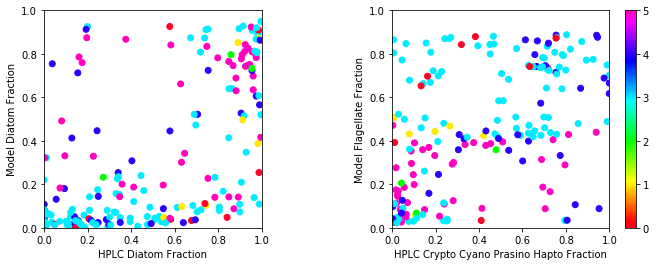

In [16]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
diatFracMod=data['mod_diatoms']/(data['mod_diatoms']+data['mod_flagellates']+data['mod_ciliates'])
diatFracObs=data['DD']/data['TchlA (ug/L)']
m=ax[0].scatter(diatFracObs,diatFracMod,
          c=data['Cluster'],cmap='gist_rainbow')
ax[0].set_xlabel('HPLC Diatom Fraction')
ax[0].set_ylabel('Model Diatom Fraction')
ax[0].set_xlim((0,1))
ax[0].set_ylim((0,1))
flFracMod=data['mod_flagellates']/(data['mod_diatoms']+data['mod_flagellates']+data['mod_ciliates'])
CCPHFracObs=data['CCPH']/data['TchlA (ug/L)']
m=ax[1].scatter(CCPHFracObs,flFracMod,
          c=data['Cluster'],cmap='gist_rainbow')
ax[1].set_xlabel('HPLC Crypto Cyano Prasino Hapto Fraction')
ax[1].set_ylabel('Model Flagellate Fraction')
ax[1].set_xlim((0,1))
ax[1].set_ylim((0,1))
ax[0].set_aspect(1)
ax[1].set_aspect(1)

fig.colorbar(m)

### Species makeup by cluster

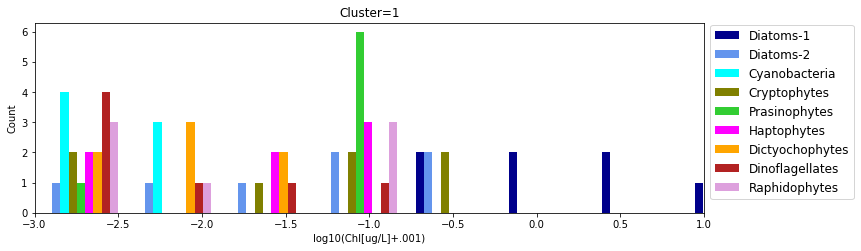

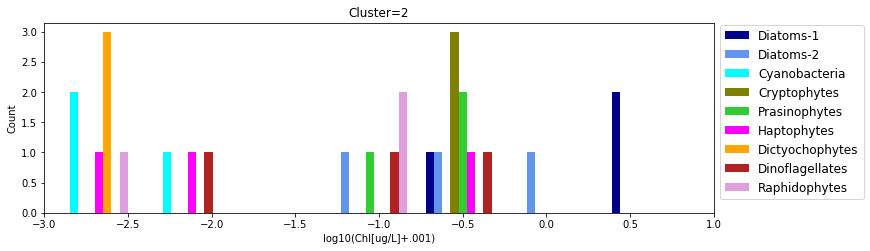

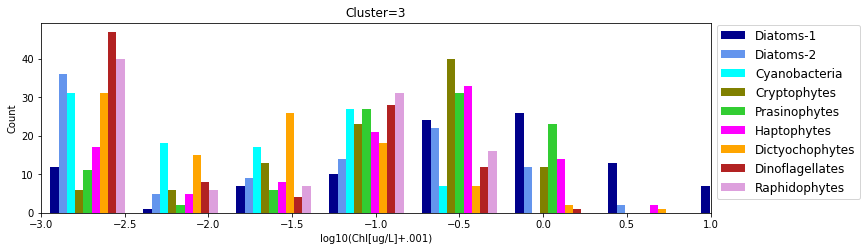

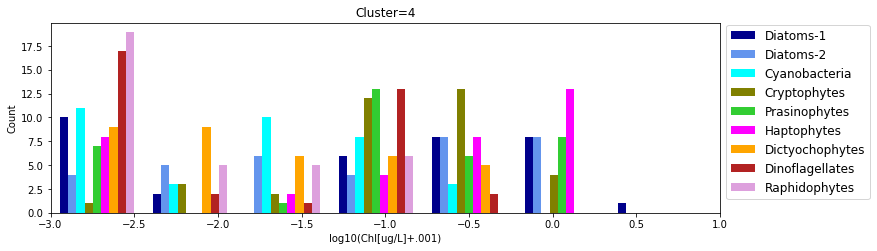

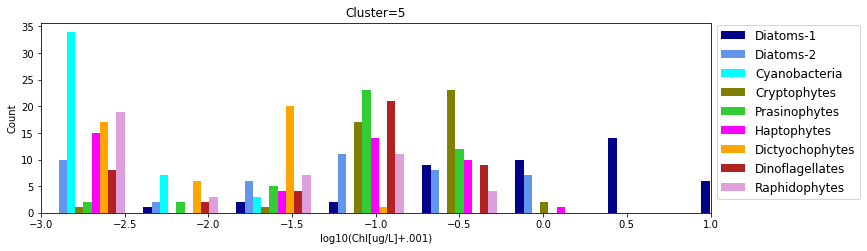

In [17]:
for icluster in range(1,6):
    fig,ax=plt.subplots(1,1,figsize=(12,3.5))
    idata=data.loc[data.Cluster==icluster]
    hplclist=('Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
           'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes')
    x=np.array([logt(idata[el]) for el in hplclist]).T
    cols=('darkblue','cornflowerblue','cyan','olive','limegreen','magenta','orange','firebrick','plum')
    bins=np.linspace(-3,2,10)
    ax.hist(x, bins, density=False, histtype='bar', color=cols, label=hplclist);
    ax.legend(prop={'size': 12},bbox_to_anchor=(1,0.04));
    ax.set_xlim(-3,1)
    ax.set_xlabel('log10(Chl[ug/L]+.001)')
    ax.set_ylabel('Count')
    ax.set_title('Cluster='+str(icluster))

### Seasonality by Cluster (color=cluster; see map at top of page)

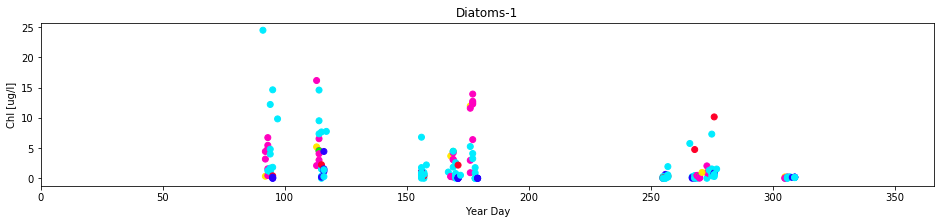

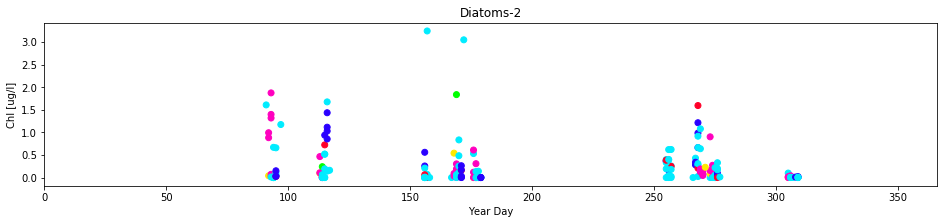

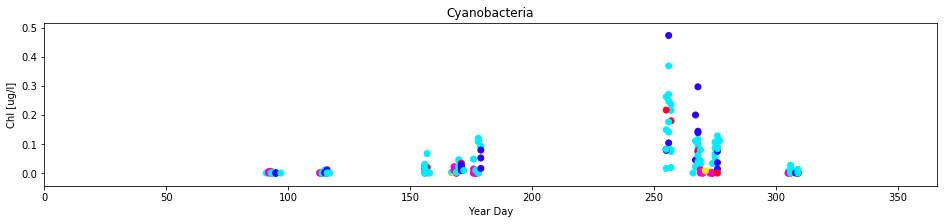

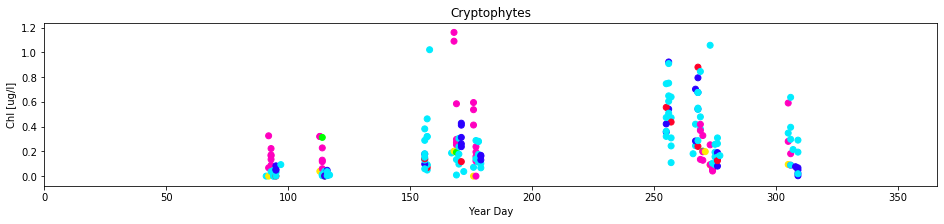

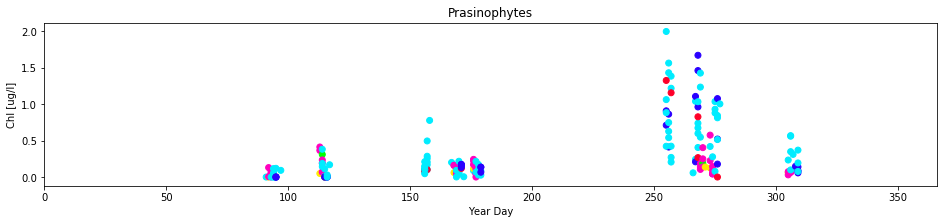

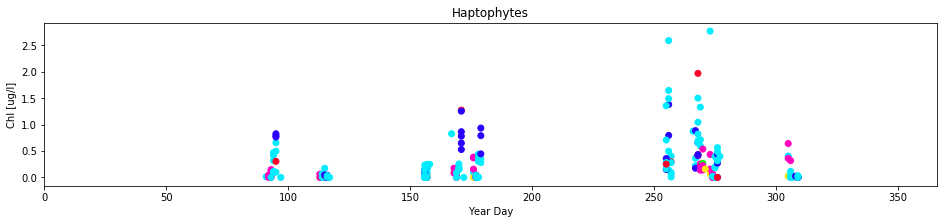

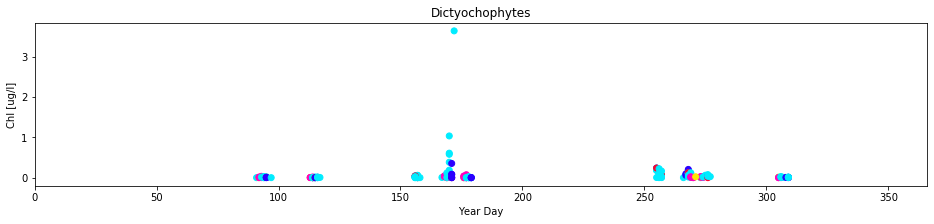

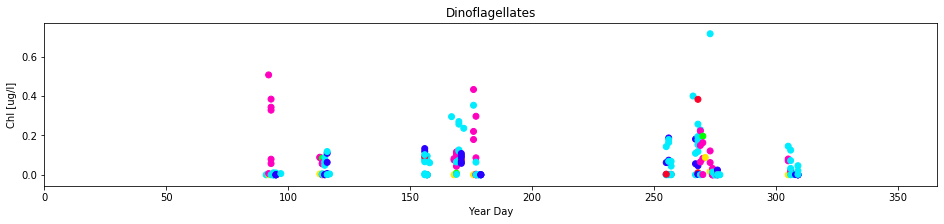

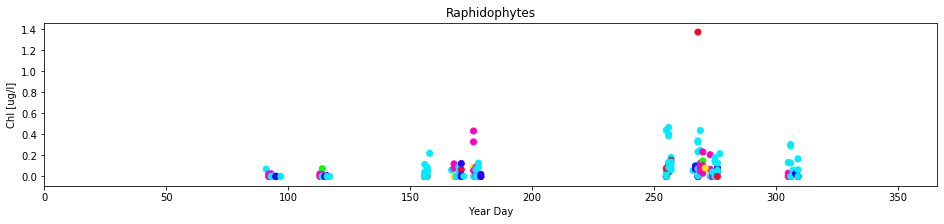

In [18]:
for i in range(0,len(hplclist)):
    fig,ax=plt.subplots(1,1,figsize=(16,3))
    ax.scatter(data['yd'],data[hplclist[i]],c=data['Cluster'],label=hplclist[i],cmap='gist_rainbow')
    #ax.set_ylim(-3,1)
    ax.set_xlim((0,366))
    ax.set_title((hplclist[i]))
    ax.set_xlabel('Year Day')
    ax.set_ylabel('Chl [ug/l]')

### Covariance Matrices

In [19]:
icluster=1
print('Cluster',icluster)
idata=data.loc[data.Cluster==icluster,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
   'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CCPH','TchlA (ug/L)',
               'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]
idata.cov()

Cluster 1


,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,17.982473,-0.085762,-0.001709,-0.138147,0.048377,-0.116030,-0.014663,-0.039840,0.073285,17.896711,-0.207509,17.708618,2.932403,3.885786,0.539620,7.357808
Diatoms-2,-0.085762,0.036747,-0.000036,0.012955,0.000391,0.007329,0.002271,0.001081,-0.001560,-0.049015,0.020639,-0.026649,0.087746,0.104741,0.005999,0.198486
Cyanobacteria,-0.001709,-0.000036,0.000010,0.000073,0.000121,0.000079,0.000002,0.000074,0.000089,-0.001745,0.000283,-0.001298,-0.002535,-0.001329,-0.000120,-0.003984
Cryptophytes,-0.138147,0.012955,0.000073,0.007169,0.001601,0.004210,0.001037,0.001568,0.000099,-0.125192,0.013054,-0.109433,-0.033948,0.010174,-0.001866,-0.025641
Prasinophytes,0.048377,0.000391,0.000121,0.001601,0.002421,0.001093,0.000135,0.000971,0.001763,0.048769,0.005236,0.056884,-0.041055,0.010529,0.001065,-0.029461
Haptophytes,-0.116030,0.007329,0.000079,0.004210,0.001093,0.003378,0.000569,0.001470,0.000553,-0.108701,0.008760,-0.097340,-0.027344,-0.002444,-0.001832,-0.031620
Dictyochophytes,-0.014663,0.002271,0.000002,0.001037,0.000135,0.000569,0.000165,0.000141,-0.000064,-0.012393,0.001742,-0.010409,-0.000573,0.004870,0.000053,0.004350
Dinoflagellates,-0.039840,0.001081,0.000074,0.001568,0.000971,0.001470,0.000141,0.001058,0.000736,-0.038759,0.004083,-0.032727,-0.024777,-0.011909,-0.001370,-0.038056
Raphidophytes,0.073285,-0.001560,0.000089,0.000099,0.001763,0.000553,-0.000064,0.000736,0.001696,0.071725,0.002504,0.076615,-0.024743,0.012039,0.001875,-0.010829
DD,17.896711,-0.049015,-0.001745,-0.125192,0.048769,-0.108701,-0.012393,-0.038759,0.071725,17.847697,-0.186870,17.681969,3.020148,3.990527,0.545619,7.556294


In [20]:
icluster=2
print('Cluster',icluster)
idata=data.loc[data.Cluster==icluster,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
   'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CCPH','TchlA (ug/L)',
               'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]
idata.cov()

Cluster 2


,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,5.830206,1.314561,-0.006969,0.073696,0.020161,-0.367340,-0.002069,-0.207422,-0.153106,7.144768,-0.280453,6.502392,4.267778,0.641032,0.097760,5.006570
Diatoms-2,1.314561,0.947550,-0.001613,-0.031364,-0.084918,-0.083827,-0.000883,-0.078686,-0.065305,2.262112,-0.201722,1.916076,2.063865,0.603229,0.043605,2.710698
Cyanobacteria,-0.006969,-0.001613,0.000008,-0.000085,-0.000018,0.000439,0.000003,0.000250,0.000185,-0.008582,0.000344,-0.007802,-0.005173,-0.000796,-0.000118,-0.006087
Cryptophytes,0.073696,-0.031364,-0.000085,0.004467,0.006847,-0.004570,0.000004,-0.000270,0.000333,0.042332,0.006659,0.049037,-0.027225,-0.025696,-0.000353,-0.053275
Prasinophytes,0.020161,-0.084918,-0.000018,0.006847,0.012361,-0.001133,0.000050,0.003668,0.003700,-0.064757,0.018057,-0.039335,-0.136593,-0.060804,-0.002624,-0.200022
Haptophytes,-0.367340,-0.083827,0.000439,-0.004570,-0.001133,0.023146,0.000131,0.013118,0.009694,-0.451168,0.017883,-0.410384,-0.270591,-0.041095,-0.006193,-0.317879
Dictyochophytes,-0.002069,-0.000883,0.000003,0.000004,0.000050,0.000131,0.000001,0.000094,0.000074,-0.002952,0.000188,-0.002595,-0.002218,-0.000521,-0.000048,-0.002787
Dinoflagellates,-0.207422,-0.078686,0.000250,-0.000270,0.003668,0.013118,0.000094,0.008944,0.006956,-0.286108,0.016766,-0.253392,-0.205832,-0.045290,-0.004535,-0.255657
Raphidophytes,-0.153106,-0.065305,0.000185,0.000333,0.003700,0.009694,0.000074,0.006956,0.005476,-0.218411,0.013912,-0.192030,-0.164154,-0.038519,-0.003587,-0.206259
DD,7.144768,2.262112,-0.008582,0.042332,-0.064757,-0.451168,-0.002952,-0.286108,-0.218411,9.406879,-0.482176,8.418468,6.331642,1.244261,0.141365,7.717268


In [21]:
icluster=3
print('Cluster',icluster)
idata=data.loc[data.Cluster==icluster,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
   'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CCPH','TchlA (ug/L)',
               'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]
idata.cov()

Cluster 3


,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,14.560905,0.331821,-0.074357,-0.303669,-0.402601,-0.423968,-0.129763,-0.054553,-0.105618,14.892726,-1.204595,13.398088,6.790147,-0.598518,0.115239,6.306869
Diatoms-2,0.331821,0.279671,0.000320,-0.003101,0.005285,-0.021247,0.112296,0.006027,-0.006412,0.611492,-0.018743,0.704635,0.164449,-0.010754,-0.011663,0.142033
Cyanobacteria,-0.074357,0.000320,0.005080,0.009279,0.020167,0.012739,0.000382,-0.000593,0.004159,-0.074038,0.047265,-0.022820,-0.060505,0.006372,-0.002540,-0.056673
Cryptophytes,-0.303669,-0.003101,0.009279,0.059971,0.071226,0.072185,-0.002133,0.010783,0.016802,-0.306770,0.212661,-0.068651,-0.269375,0.040940,-0.009456,-0.237891
Prasinophytes,-0.402601,0.005285,0.020167,0.071226,0.183340,0.065970,-0.004962,-0.000888,0.028529,-0.397315,0.340703,-0.033944,-0.402960,-0.017056,-0.024719,-0.444736
Haptophytes,-0.423968,-0.021247,0.012739,0.072185,0.065970,0.243609,-0.007217,0.031685,0.025328,-0.445215,0.394504,-0.000925,-0.223072,0.000083,-0.012931,-0.235920
Dictyochophytes,-0.129763,0.112296,0.000382,-0.002133,-0.004962,-0.007217,0.147774,0.010101,-0.002210,-0.017467,-0.013930,0.124225,-0.119626,0.066207,-0.008462,-0.061881
Dinoflagellates,-0.054553,0.006027,-0.000593,0.010783,-0.000888,0.031685,0.010101,0.011996,0.001120,-0.048526,0.040986,0.015668,-0.071370,0.022288,-0.001079,-0.050162
Raphidophytes,-0.105618,-0.006412,0.004159,0.016802,0.028529,0.025328,-0.002210,0.001120,0.012958,-0.112030,0.074819,-0.025326,-0.090100,-0.004134,-0.004899,-0.099133
DD,14.892726,0.611492,-0.074038,-0.306770,-0.397315,-0.445215,-0.017467,-0.048526,-0.112030,15.504218,-1.223338,14.102723,6.954597,-0.609272,0.103577,6.448902


In [22]:
icluster=4
print('Cluster',icluster)
idata=data.loc[data.Cluster==icluster,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
   'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CCPH','TchlA (ug/L)',
               'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]
idata.cov()

Cluster 4


,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,0.668880,0.175677,-0.013244,-0.058728,-0.071523,-0.127238,-0.015159,-0.001292,-0.001346,0.844556,-0.270733,0.555942,0.423107,-0.234634,0.029243,0.217717
Diatoms-2,0.175677,0.178600,0.003750,0.007990,0.045230,-0.062868,0.007154,0.000657,-0.003882,0.354277,-0.005898,0.352330,0.088623,-0.088244,0.018460,0.018839
Cyanobacteria,-0.013244,0.003750,0.009544,0.021020,0.032777,0.017578,0.002652,0.002270,0.001457,-0.009495,0.080919,0.077804,-0.033450,0.002358,-0.003331,-0.034423
Cryptophytes,-0.058728,0.007990,0.021020,0.062095,0.090645,0.057250,0.011558,0.006822,0.003713,-0.050738,0.231010,0.202382,-0.110073,0.067806,-0.014055,-0.056321
Prasinophytes,-0.071523,0.045230,0.032777,0.090645,0.206562,0.037459,0.022546,0.003113,0.003496,-0.026292,0.367444,0.370431,-0.209902,0.012881,-0.026286,-0.223306
Haptophytes,-0.127238,-0.062868,0.017578,0.057250,0.037459,0.159663,0.003192,0.008735,0.004708,-0.190106,0.271950,0.098521,-0.044482,0.151625,-0.010354,0.096789
Dictyochophytes,-0.015159,0.007154,0.002652,0.011558,0.022546,0.003192,0.007441,0.000705,0.000052,-0.008004,0.039947,0.040165,-0.029969,0.035026,-0.003942,0.001115
Dinoflagellates,-0.001292,0.000657,0.002270,0.006822,0.003113,0.008735,0.000705,0.003055,0.000873,-0.000635,0.020941,0.024927,0.003345,0.017853,0.002822,0.024020
Raphidophytes,-0.001346,-0.003882,0.001457,0.003713,0.003496,0.004708,0.000052,0.000873,0.001226,-0.005228,0.013374,0.010286,-0.009865,-0.003203,-0.002084,-0.015152
DD,0.844556,0.354277,-0.009495,-0.050738,-0.026292,-0.190106,-0.008004,-0.000635,-0.005228,1.198833,-0.276631,0.908272,0.511731,-0.322877,0.047703,0.236556


In [23]:
icluster=5
print('Cluster',icluster)
idata=data.loc[data.Cluster==icluster,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
   'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CCPH','TchlA (ug/L)',
               'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]
idata.cov()

Cluster 5


,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,19.085968,0.278712,-0.005160,-0.169379,0.018722,-0.289899,-0.017112,0.082836,-0.095718,19.364680,-0.445716,18.888450,4.766033,0.964032,0.285393,6.015458
Diatoms-2,0.278712,0.184646,-0.000004,-0.009744,-0.000155,-0.009780,-0.000486,0.031448,-0.003436,0.463358,-0.019683,0.471144,-0.120053,-0.041605,0.001191,-0.160467
Cyanobacteria,-0.005160,-0.000004,0.000026,0.000856,0.000021,0.000097,0.000033,0.000133,0.000178,-0.005164,0.001000,-0.003821,0.006096,0.000667,0.000103,0.006866
Cryptophytes,-0.169379,-0.009744,0.000856,0.059843,0.007344,0.013938,0.001092,0.006859,0.009600,-0.179124,0.081980,-0.079626,0.445319,0.051696,0.008743,0.505758
Prasinophytes,0.018722,-0.000155,0.000021,0.007344,0.014842,0.007229,-0.000082,0.001771,0.005685,0.018567,0.029436,0.055389,0.047950,-0.008481,0.001845,0.041314
Haptophytes,-0.289899,-0.009780,0.000097,0.013938,0.007229,0.025317,0.000231,0.002152,0.008472,-0.299679,0.046580,-0.242236,-0.054482,-0.012418,-0.005339,-0.072239
Dictyochophytes,-0.017112,-0.000486,0.000033,0.001092,-0.000082,0.000231,0.000237,0.000217,0.000641,-0.017599,0.001274,-0.015228,0.013861,0.001236,0.000294,0.015391
Dinoflagellates,0.082836,0.031448,0.000133,0.006859,0.001771,0.002152,0.000217,0.015759,0.004042,0.114285,0.010915,0.145199,0.061037,0.003298,0.003492,0.067827
Raphidophytes,-0.095718,-0.003436,0.000178,0.009600,0.005685,0.008472,0.000641,0.004042,0.008336,-0.099154,0.023935,-0.062194,0.075149,0.005624,0.001576,0.082349
DD,19.364680,0.463358,-0.005164,-0.179124,0.018567,-0.299679,-0.017599,0.114285,-0.099154,19.828038,-0.465400,19.359594,4.645979,0.922428,0.286584,5.854991


### Correlation matrices

In [24]:
icluster=1
print('Cluster',icluster)
idata=data.loc[data.Cluster==icluster,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
   'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CCPH','TchlA (ug/L)',
               'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]
idata.corr()

Cluster 1


,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.000000,-0.105501,-0.128087,-0.384745,0.231871,-0.470756,-0.269230,-0.288794,0.419654,0.998981,-0.295988,0.996408,0.481240,0.734380,0.909275,0.712966
Diatoms-2,-0.105501,1.000000,-0.059396,0.798136,0.041510,0.657758,0.922213,0.173292,-0.197633,-0.060523,0.651243,-0.033170,0.318550,0.437899,0.223603,0.425464
Cyanobacteria,-0.128087,-0.059396,1.000000,0.273762,0.782517,0.432655,0.037699,0.727435,0.687435,-0.131265,0.544229,-0.098402,-0.560466,-0.338490,-0.272749,-0.520161
Cryptophytes,-0.384745,0.798136,0.273762,1.000000,0.384389,0.855388,0.953205,0.569213,0.028358,-0.349979,0.932492,-0.308378,-0.279022,0.096293,-0.157463,-0.124432
Prasinophytes,0.231871,0.041510,0.782517,0.384389,1.000000,0.382096,0.214170,0.606875,0.870212,0.234629,0.643695,0.275866,-0.580713,0.171504,0.154658,-0.246054
Haptophytes,-0.470756,0.657758,0.432655,0.855388,0.382096,1.000000,0.761622,0.777240,0.230974,-0.442685,0.911610,-0.399593,-0.327395,-0.033694,-0.225277,-0.223540
Dictyochophytes,-0.269230,0.922213,0.037699,0.953205,0.214170,0.761622,1.000000,0.337586,-0.121049,-0.228399,0.820409,-0.193387,-0.031024,0.303904,0.029280,0.139183
Dinoflagellates,-0.288794,0.173292,0.727435,0.569213,0.606875,0.777240,0.337586,1.000000,0.549526,-0.282019,0.759233,-0.240038,-0.530046,-0.293379,-0.300862,-0.480687
Raphidophytes,0.419654,-0.197633,0.687435,0.028358,0.870212,0.230974,-0.121049,0.549526,1.000000,0.412268,0.367786,0.443908,-0.418130,0.234293,0.325341,-0.108049
DD,0.998981,-0.060523,-0.131265,-0.349979,0.234629,-0.442685,-0.228399,-0.282019,0.412268,1.000000,-0.267553,0.998658,0.497508,0.757017,0.922847,0.734959


In [25]:
icluster=2
print('Cluster',icluster)
idata=data.loc[data.Cluster==icluster,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
   'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CCPH','TchlA (ug/L)',
               'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]
idata.corr()

Cluster 2


,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.000000,0.559291,-0.999838,0.456658,0.075098,-0.999967,-0.856877,-0.908337,-0.856877,0.964769,-0.560487,0.979229,0.791426,0.423165,0.834615,0.726659
Diatoms-2,0.559291,1.000000,-0.574134,-0.482084,-0.784629,-0.566034,-0.906596,-0.854733,-0.906596,0.757687,-0.999999,0.715755,0.949359,0.987764,0.923418,0.975916
Cyanobacteria,-0.999838,-0.574134,1.000000,-0.440556,-0.057121,0.999951,0.866025,0.915724,0.866025,-0.969352,0.575316,-0.982723,-0.802310,-0.439420,-0.844403,-0.738918
Cryptophytes,0.456658,-0.482084,-0.440556,1.000000,0.921424,-0.449386,0.067329,-0.042716,0.067329,0.206506,0.480818,0.266790,-0.182397,-0.612821,-0.108912,-0.279348
Prasinophytes,0.075098,-0.784629,-0.057121,0.921424,1.000000,-0.066962,0.449715,0.348844,0.449715,-0.189903,0.783733,-0.128648,-0.550105,-0.871715,-0.486600,-0.630487
Haptophytes,-0.999967,-0.566034,0.999951,-0.449386,-0.066962,1.000000,0.861054,0.911718,0.861054,-0.966883,0.567224,-0.980850,-0.796385,-0.430542,-0.839080,-0.732239
Dictyochophytes,-0.856877,-0.906596,0.866025,0.067329,0.449715,0.861054,1.000000,0.993944,1.000000,-0.962321,0.907204,-0.943605,-0.993275,-0.829690,-0.999129,-0.976819
Dinoflagellates,-0.908337,-0.854733,0.915724,-0.042716,0.348844,0.911718,0.993944,1.000000,0.993944,-0.986373,0.855482,-0.974271,-0.974536,-0.763323,-0.988492,-0.947381
Raphidophytes,-0.856877,-0.906596,0.866025,0.067329,0.449715,0.861054,1.000000,0.993944,1.000000,-0.962321,0.907204,-0.943605,-0.993275,-0.829690,-0.999129,-0.976819
DD,0.964769,0.757687,-0.969352,0.206506,-0.189903,-0.966883,-0.962321,-0.986373,-0.962321,1.000000,-0.758629,0.998075,0.924366,0.646638,0.950134,0.881806


In [26]:
icluster=3
print('Cluster',icluster)
idata=data.loc[data.Cluster==icluster,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
   'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CCPH','TchlA (ug/L)',
               'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]
idata.corr()

Cluster 3


,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.000000,0.164432,-0.273405,-0.324963,-0.246406,-0.225108,-0.088462,-0.130526,-0.243153,0.991186,-0.316451,0.935365,0.651133,-0.155141,0.162084,0.618665
Diatoms-2,0.164432,1.000000,0.008477,-0.023942,0.023341,-0.081401,0.552383,0.104048,-0.106513,0.293658,-0.035528,0.354955,0.113787,-0.020113,-0.118360,0.100531
Cyanobacteria,-0.273405,0.008477,1.000000,0.531606,0.660840,0.362140,0.013960,-0.075996,0.512617,-0.263818,0.664779,-0.085296,-0.310637,0.088426,-0.191239,-0.297638
Cryptophytes,-0.324963,-0.023942,0.531606,1.000000,0.679258,0.597210,-0.022661,0.402021,0.602743,-0.318138,0.870511,-0.074681,-0.402504,0.165356,-0.207235,-0.363615
Prasinophytes,-0.246406,0.023341,0.660840,0.679258,1.000000,0.312156,-0.030147,-0.018943,0.585328,-0.235658,0.797640,-0.021119,-0.344365,-0.039400,-0.309840,-0.388785
Haptophytes,-0.225108,-0.081401,0.362140,0.597210,0.312156,1.000000,-0.038035,0.586110,0.450805,-0.229086,0.801242,-0.000499,-0.165380,0.000166,-0.140611,-0.178918
Dictyochophytes,-0.088462,0.552383,0.013960,-0.022661,-0.030147,-0.038035,1.000000,0.239917,-0.050509,-0.011540,-0.036324,0.086088,-0.113870,0.170351,-0.118140,-0.060255
Dinoflagellates,-0.130526,0.104048,-0.075996,0.402021,-0.018943,0.586110,0.239917,1.000000,0.089811,-0.112519,0.375123,0.038108,-0.238440,0.201272,-0.052864,-0.171428
Raphidophytes,-0.243153,-0.106513,0.512617,0.602743,0.585328,0.450805,-0.050509,0.089811,1.000000,-0.249945,0.658878,-0.059270,-0.289631,-0.035918,-0.230991,-0.325979
DD,0.991186,0.293658,-0.263818,-0.318138,-0.235658,-0.229086,-0.011540,-0.112519,-0.249945,1.000000,-0.311445,0.954137,0.646297,-0.153048,0.141180,0.613051


In [27]:
icluster=4
print('Cluster',icluster)
idata=data.loc[data.Cluster==icluster,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
   'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CCPH','TchlA (ug/L)',
               'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]
idata.corr()

Cluster 4


,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.000000,0.508275,-0.165768,-0.288165,-0.192417,-0.389352,-0.214873,-0.028576,-0.046990,0.943138,-0.339393,0.516378,0.363429,-0.302924,0.143840,0.149701
Diatoms-2,0.508275,1.000000,0.090820,0.075874,0.235486,-0.372293,0.196250,0.028114,-0.262349,0.765636,-0.014307,0.633316,0.147316,-0.220476,0.175719,0.025069
Cyanobacteria,-0.165768,0.090820,1.000000,0.863469,0.738230,0.450315,0.314656,0.420440,0.425904,-0.088767,0.849240,0.605007,-0.240536,0.025482,-0.137188,-0.198156
Cryptophytes,-0.288165,0.075874,0.863469,1.000000,0.800374,0.574969,0.537709,0.495324,0.425470,-0.185961,0.950471,0.616958,-0.310309,0.287317,-0.226897,-0.127101
Prasinophytes,-0.192417,0.235486,0.738230,0.800374,1.000000,0.206269,0.575104,0.123917,0.219690,-0.052835,0.828900,0.619147,-0.324440,0.029926,-0.232664,-0.276301
Haptophytes,-0.389352,-0.372293,0.450315,0.574969,0.206269,1.000000,0.092597,0.395508,0.336501,-0.434525,0.697788,0.187301,-0.078203,0.400670,-0.104246,0.136216
Dictyochophytes,-0.214873,0.196250,0.314656,0.537709,0.575104,0.092597,1.000000,0.147862,0.017152,-0.084752,0.474809,0.353718,-0.244071,0.428750,-0.183841,0.007267
Dinoflagellates,-0.028576,0.028114,0.420440,0.495324,0.123917,0.395508,0.147862,1.000000,0.451007,-0.010494,0.388430,0.342576,0.042517,0.341046,0.205372,0.244379
Raphidophytes,-0.046990,-0.262349,0.425904,0.425470,0.219690,0.336501,0.017152,0.451007,1.000000,-0.136360,0.391585,0.223131,-0.197903,-0.096597,-0.239360,-0.243328
DD,0.943138,0.765636,-0.088767,-0.185961,-0.052835,-0.434525,-0.084752,-0.010494,-0.136360,1.000000,-0.259034,0.630157,0.328326,-0.311370,0.175265,0.121496


In [28]:
icluster=5
print('Cluster',icluster)
idata=data.loc[data.Cluster==icluster,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
   'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CCPH','TchlA (ug/L)',
               'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]
idata.corr()

Cluster 5


,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.000000,0.148467,-0.232265,-0.158488,0.035176,-0.417042,-0.254348,0.151045,-0.239964,0.995436,-0.255864,0.987828,0.389938,0.421184,0.640591,0.423702
Diatoms-2,0.148467,1.000000,-0.001709,-0.092699,-0.002969,-0.143037,-0.073506,0.583001,-0.087582,0.242163,-0.114877,0.250511,-0.099862,-0.184803,0.027175,-0.114912
Cyanobacteria,-0.232265,-0.001709,1.000000,0.687849,0.034613,0.119474,0.425095,0.207678,0.382328,-0.228043,0.492998,-0.171693,0.428516,0.250218,0.197940,0.415460
Cryptophytes,-0.158488,-0.092699,0.687849,1.000000,0.246412,0.358074,0.289762,0.223349,0.429798,-0.164439,0.840444,-0.074368,0.650669,0.403354,0.350450,0.636185
Prasinophytes,0.035176,-0.002969,0.034613,0.246412,1.000000,0.372909,-0.043510,0.115825,0.511088,0.034225,0.605949,0.103877,0.140683,-0.132876,0.148480,0.104351
Haptophytes,-0.417042,-0.143037,0.119474,0.358074,0.372909,1.000000,0.094206,0.107764,0.583172,-0.422967,0.734177,-0.347834,-0.122389,-0.148961,-0.329063,-0.139705
Dictyochophytes,-0.254348,-0.073506,0.425095,0.289762,-0.043510,0.094206,1.000000,0.112127,0.455527,-0.256637,0.207489,-0.225927,0.321705,0.153247,0.187287,0.307539
Dinoflagellates,0.151045,0.583001,0.207678,0.223349,0.115825,0.107764,0.112127,1.000000,0.352636,0.204451,0.218063,0.264270,0.173793,0.050141,0.272778,0.166262
Raphidophytes,-0.239964,-0.087582,0.382328,0.429798,0.511088,0.583172,0.455527,0.352636,1.000000,-0.243882,0.657418,-0.155633,0.294190,0.117561,0.169267,0.277533
DD,0.995436,0.242163,-0.228043,-0.164439,0.034225,-0.422967,-0.256637,0.204451,-0.243882,1.000000,-0.262116,0.993341,0.372935,0.395394,0.631112,0.404608
